# RNN test file

In [1]:
########Load required Modules
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
######import functions 
import torch.nn.functional as F
from torch.autograd import Variable
###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

# Load test Dataset

In [3]:
# load test set
dataset_test = pd.read_csv("val.csv")

In [4]:
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,2183.760010,2185.439941,2177.850098,2180.889893,2180.889893,3327550000
1,2016-08-09,2182.239990,2187.659912,2178.610107,2181.739990,2181.739990,3334300000
2,2016-08-10,2182.810059,2183.409912,2172.000000,2175.489990,2175.489990,3254950000
3,2016-08-11,2177.969971,2188.449951,2177.969971,2185.790039,2185.790039,3423160000
4,2016-08-12,2183.739990,2186.280029,2179.419922,2184.050049,2184.050049,3000660000


In [5]:
dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])
dataset_test = dataset_test[['Close']]

In [6]:
dataset_test.shape

(806, 1)

# Data preprocessing

In [7]:
scaler_test = MinMaxScaler()
dataset_test_scaled = scaler_test.fit_transform(dataset_test.Close.values.reshape(-1,1))
dataset_test_scaled.shape

(806, 1)

# Prepare the input sequence

In [8]:
window = 21

In [9]:
x_test = []
y_test = []
for index in range(len(dataset_test_scaled) - window):
    need_data = dataset_test_scaled[index: index + window]
    x_test.append(need_data[:-1])
    y_test.append(need_data[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
x_test.shape, y_test.shape

((785, 20, 1), (785, 1))

In [11]:
x_test_torch = torch.from_numpy(x_test).type(torch.Tensor)
y_test_torch = torch.from_numpy(y_test).type(torch.Tensor)

# Load pre-trained model

In [12]:
##### DEFINE RNN net as described above: 
class StackedRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(StackedRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Create a list to hold multiple RNN layers
        self.rnn_layers = nn.ModuleList([nn.RNN(input_dim if i == 0 else hidden_dim,
                                                hidden_dim,
                                                batch_first=True)
                                         for i in range(num_layers)])
        
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden states
        hiddens = [torch.zeros(1, x.size(0), self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        
        # Forward pass through each RNN layer
        for i, rnn_layer in enumerate(self.rnn_layers):
            out, hiddens[i] = rnn_layer(x if i == 0 else out, hiddens[i])
        
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Set hyperparameter
num_epochs = 200
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1

In [14]:
########Load pretrain model
# Create an instance of the StackedRNN model
final_model = StackedRNN(input_dim, hidden_dim, output_dim, num_layers)

# Load the model's state dictionary
final_model.load_state_dict(torch.load('stacked_rnn_model.pth'))

# Move the model to the specified device
final_model = final_model.to(device)

# Evaluate on the test set

In [15]:
########Evaluate model
final_model.eval()
y_test_pred = final_model(x_test_torch.to(device))
y_test_model = scaler_test.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_original = scaler_test.inverse_transform(y_test)

In [16]:
y_test_model.shape, y_test_original.shape

((785, 1), (785, 1))

<Figure size 2560x1920 with 0 Axes>

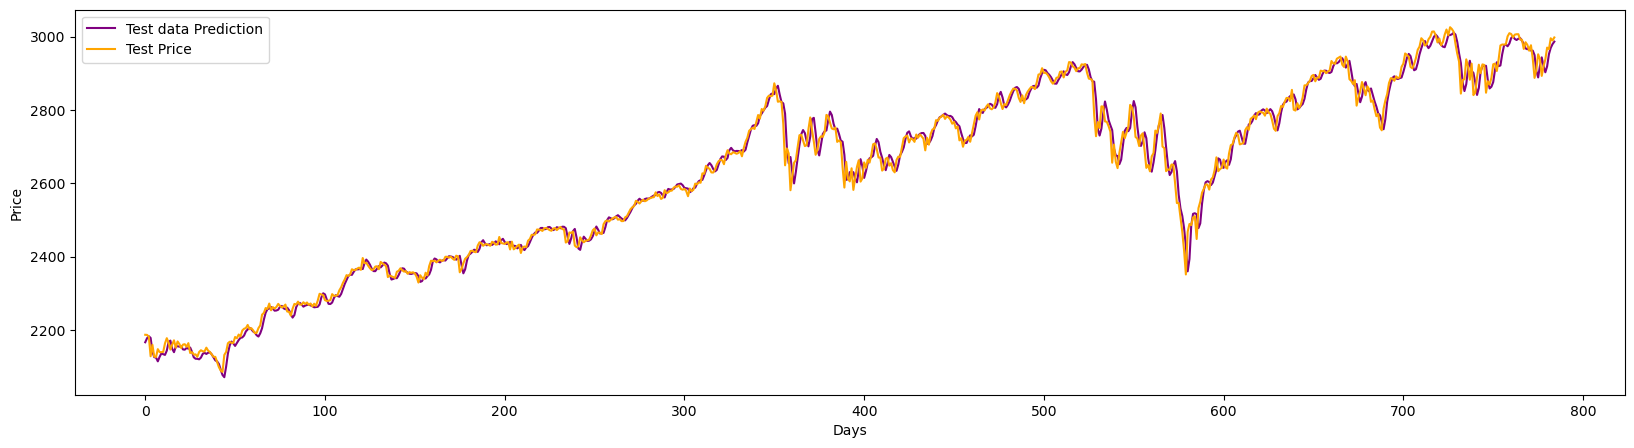

In [17]:
######visualization for single test
# N_original,N_test = len(y_train_original),len(y_test_model)
N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) #+ N_original

## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
# plt.plot(y_train_original, color = 'blue', label = 'Price')
# plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(index_test, y_test_model, color = 'purple', label = 'Test data Prediction')
plt.plot(index_test, y_test_original, color = 'orange', label = 'Test Price')
plt.legend()
plt.savefig("Test-Result1.png", dpi=500)
plt.show()
df_LSTM_result = pd.DataFrame({'Original':y_test_original.flatten(),'Test Prediction':y_test_model.flatten()})
df_LSTM_result.to_csv(r"Test-Result.csv",sep=',')

# Backtest

In [18]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    cash = initial_cash
    shares = 0
    total_assets = initial_cash
    # make sure each time only do one strategy （state machine）
    position = 0  # 0 for no position, 1 for long, -1 for short

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        if position == 0:  # No position
            # long buy
            if predicted_change > threshold and cash >= original_prices[i]:
                shares_bought = cash // original_prices[i]
                shares += shares_bought
                cash -= shares_bought * original_prices[i]
                position = 1  # Long position opened
            # short buy
            elif predicted_change < -threshold and cash >= original_prices[i]:
                shares_sold_short = cash // original_prices[i]
                shares += shares_sold_short
                cash -= shares_sold_short * original_prices[i]
                position = -1  # Short position opened

        elif position == 1:  # Long position
            # long sell
            if predicted_change < -threshold:
                cash += shares * original_prices[i]
                shares = 0
                position = 0  # Exit long position
            # short sell
        elif position == -1:  # Short position
            if predicted_change > threshold:
                cash += shares * original_prices[i]
                shares = 0
                position = 0  # Exit short position

        total_assets = cash + shares * original_prices[i]

    return total_assets

In [20]:
initial_cash = 500000
best_threshold = 0
best_return_rate = 0

# seeking best threshold between 0.0001 to 0.009
for threshold in range(1, 100):
    threshold /= 10000  # 将范围调整为0.0001到0.0099
    # get the "final_assets" from backtest function 
    final_assets = backtest(y_test_model[:, 0], y_test_original[:, 0], threshold=threshold, initial_cash=initial_cash)
    total_return = final_assets - initial_cash
    return_rate = (total_return / initial_cash) * 100
    # sorting return rate find the best one
    if return_rate > best_return_rate:
        best_return_rate = return_rate
        best_threshold = threshold

#print("Best Threshold:", best_threshold, "Best Return Rate:", best_return_rate)
print("Best Threshold:", best_threshold, "Final Assets:", final_assets, "Total Return:", total_return,"Best Return Rate:", best_return_rate,)

Best Threshold: 0.0041 Final Assets: 661161.3198242188 Total Return: 161161.31982421875 Best Return Rate: 46.960853125
